In [2]:
###Importamos las biliotecas necesarias:
##TensorFlow, Keras a partir de TensorFlow; y de Keras además importamos el comando para crear capas
import tensorflow as tf #Importamos TensorFlow
from tensorflow import keras #Importamos keras desde TensorFlow
from tensorflow.keras import layers #Importamos la función para crear capas de redes neuronales desde keras
from tensorflow.keras.models import Model #Importamos la clase Model de tensorflow, lo que permite crear modelos de DL como clases, con arquitecturas más complejas que usar Sequential
from tensorflow.keras.callbacks import EarlyStopping #Importamos la función para realizar el earlystopping desde la biblioteca de callbacks de keras
from tensorflow.keras.models import load_model #Cargamos la función para poder importar modelos de machine learning
from tensorflow.keras.utils import plot_model #Cargamos la función para poder realizar representaciones de la arquitectura de modelos
from keras.saving import register_keras_serializable #Función de queras necesaria para guardar modelos que se hayan definidos como clases

##Importamos keras tuning para poder optimizar los hiperparametros del modelo
import keras_tuner as kt

##Importamos cuda para poder liberar el espacio de la GPU
from numba import cuda

##Importamos Pandas para trabajar con DataFrames
import pandas as pd

##Importamos Numpy para incluir más funciones matemáticas
import numpy as np

##Importamos la biblioteca itertools para tener herramientas de iteracián sobre diferentes conjuntos
import itertools

##Importamos MatPlotLib para realizar representaciones
import matplotlib.pyplot as plt
from matplotlib import gridspec #Es un paquete de matplotlib que permite realizar figuras de varias subfiguras

##Importamos la funcion display de la biblioteca IPython.display, que permite mostrar contenido de manera mas enriquecida. Tambien importamos Image para poder mostrar gráficos
from IPython.display import display
from IPython.display import Image

##Importamos varias funciones de las bibliotecas de sklearn
from sklearn.model_selection import train_test_split #Es una función que se utiliza para dividir un conjunto de datos en conjuntos de entrenamiento y prueba de forma aleatoria.
from sklearn.metrics import accuracy_score, precision_score, recall_score #Funciones para evaluar el rendimiento de modelos de clasificcación: accuracy_score() fracción de muestras clasificadas correctaente (precision del modelo), precision_score() precision para una clase en particular, recall_score() sensibilidad para cada clase (tasa de verdaderos positivos)

##Importamos el modulo time para poder medir el tiempo de ejecución del código
import time

##Immportamos el generador de números aleatorios
import random

##Importamos la biblioteca os para poder configurar la sesion de tensorflow
import os

In [3]:
##Función para establecer la sesion de tensorflow de tal manera que solo use un tercio de la memoria de la GPU. Siempre ejecutar esta celda
def set_tf_session(gpu_memory = 0.20):
    #Establecemos la fraccion de memoria de GPU a utilizar en la sesion. Por defecto emplea el 100%
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = gpu_memory)
    #Iniciamos la sesión de tensorflow con la fracción de memoria que hemos establecido
    sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))
    return sess

#Iniciamos la sesión con la fracción de memoria deseada de GPU
set_tf_session()

2024-06-17 07:14:04.929596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4831 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [4]:
#Definimos una función para representar de manera comoda dos señales diferentes aleatorias en un mismo gráfico, que provengan del mismo conjunto de datos
def plot_pulsos(data):
    #Generar dos números enteros aleatorios entre 1 y el tamaño total del dataframe
    n_random = random.randint(1, data.shape[0])
    m_random = random.randint(1, data.shape[0])
    
    #Representación de las señales en un plot
    plt.figure(figsize = (10, 5))
    plt.plot(data.iloc[n_random], label = "Señal 1", color = "blue")
    plt.plot(data.iloc[m_random], label = "Señal 2", color = "red")
    plt.title('Señal')
    plt.xticks([])
    plt.ylabel('Valor')
    plt.show()

In [5]:
#Función para normalizar las señales. Proporciona dos opciones: 1 para normalizar a [0,1] y 2 para normalizar respecto al valor máximo
#Por defecto normaliza a escala [0,1]
def normalizacion(df, tipo = 1):
    #Normalización [0,1]
    if tipo == 1:
        maximos_fila = df.max(axis = 1).to_numpy() #Extraemos el valor máximo de las filas
        minimos_fila = df.min(axis = 1).to_numpy() #Extraemos el valor mínimo de las filas
        df = (df - minimos_fila[:, None])/(maximos_fila[:, None] - minimos_fila[:, None]) #Normalizamos los valores del Dataframe
        return df
    
    #Normalización respecto al máximo
    if tipo == 2:
        maximos_fila = df.max(axis = 1).to_numpy() #Extraemos el valor máximos de las filas
        df = df/maximos_fila[:, None] #Dividimos cada fila por su máximo
        return df

In [6]:
##Función para cambiar el formato del input del autoencoder y que sea compatible con papas convolucionales 1D
def convert_to_tensor(df):
    #Convertimos el dataframe a un tensor
    tensor = tf.convert_to_tensor(df, dtype = tf.float32)
    #Añadimos la dimensión de canal 
    tensor = tf.expand_dims(tensor, axis = 2)
    return tensor

In [7]:
##Pasamos a definir el modelo de autoencoder que vamos a emplear. Lo creamos como una clase de keras y heredando la clase padre Model
#Buscamos que el encoder sea capaz de reproducir las señales con las que le entrenamos. Tanto el encoder como el decoder va a estar compuesto por capas densas
#Este primer modelo es una adaptación a un solo segmento de la arquitectura propuesta en la tesis de Liverpool.
@register_keras_serializable() #Necesario añadirlo justo antes de definir el modelo como una clase para poder guardarlo correctamente una vez entrenado.
class Autoencoder_V1(Model):
    #Creamos la función que inicializa el modelo de autoencoder
    #Como argumento la clase toma un diccionario con los hiperparametros del modelo
    def __init__(self, hyper_params,**kwargs):
        #Inicializamos la clase padre de la que estamos heredando propiedades para que el modelo funcione correctaente
        super(Autoencoder_V1, self).__init__(**kwargs)
        #Definimos las caracteristicas de las diferentes capas como hiperparámetros ajustable del modelo
        self.hyper_params = hyper_params #Definimos los hiperparámetros como un a variable de clase
        self.filters_cv = self.hyper_params["filters_cv"] #Filtros de la capa convolucional
        self.units_encoder = self.hyper_params["units_encoder"] #Neuronas de la capa densa en el encoder
        self.units_decoder = self.hyper_params["units_decoder"] #Neuronas de la capa densa en el decoder
        self.latem_dimension = self.hyper_params["latem_dimension"] #Dimensión del espacio latente
        self.l1_penalty = self.hyper_params["l1_penalty"] #Factor de penalización lineal a las capas
        self.l2_penalty = self.hyper_params["l2_penalty"] #Factor de penalización cuadrático a las capas

        #Definimos la parte del encoder (codificación de la señal al espacio de dimensión reducida).
        self.encoder = keras.Sequential([
            #Capa que define la dimensión de entrada
            layers.Input(shape = [100, 1]),

            #Bloque convolucional para la detección de caracteristicas en la señal
            layers.Conv1D(filters = self.filters_cv, kernel_size = 3, padding = "valid", strides = 1, kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)),
            layers.BatchNormalization(), #Normalización
            layers.Activation("relu"),
            layers.MaxPool1D(),

            #Bloque de capas densas para la reducción de la dimensión
            layers.Flatten(), #Aplanamos a una dimensián la capa convolucional
            #1º capa densa
            layers.Dense(units = self.units_encoder, kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)),
            layers.BatchNormalization(), #Normalización
            layers.Activation("relu"),
            #2º capa densa
            layers.Dense(units = self.latem_dimension, kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)),
            layers.BatchNormalization(), #Normalización
            layers.Activation("relu"),
        ])

        #Definimos la parte del decoder (reconstrucción de la señal), como una serie de capas densas con función de activación ReLU
        self.decoder = keras.Sequential([
            #Capa que define la dimensión de entrada del espacio latente
            layers.Input(shape = [self.latem_dimension]),

            #Bloque de capas densas para la reconstrucción de la señal
            layers.Dense(units = self.units_decoder, kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)),
            layers.BatchNormalization(), #Normalización
            layers.Activation("relu"),

            #Capa de salida con función de activación sigmoid dado los datos de entrada estan acotados en [0,1]
            layers.Dense(units = 100, activation = "sigmoid", kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty))
        ])

    #Definimos como se va comportar el modelo cuando reciba datos de entrada
    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    #Modificamos las funciones de get_config() y from_config() para que la serialización del modelo al guardarlo se haga correctamente
    def get_config(self):
        config = super(Autoencoder_V1, self).get_config()
        config.update({
            'hyper_params': self.hyper_params,
        })
        return config

    @classmethod
    def from_config(cls, config):
        hyper_params = config.pop('hyper_params')
        return cls(hyper_params, **config)

In [8]:
##Una vez definido el modelo de autoencoder debemos definir el hipermodelo asociado a dicho modelo para poder ajustar los hiperparámetros que hemos dejado libres en la arquitectura del modelo.
#Para ello instanciamos la clase que define el autoencoder dentro de una nueva clase kt.HyperModel que vamos a definir para poder optimizar los hiperparámetros
class AE_HyperModel(kt.HyperModel):
    #En primer lugar inicializamos la calse, donde se va a definir el diccionario que contiene los hiperparámetros que se quieren optimizar
    def __init__(self):
        self.hyper_params = {
            #Hiperparámetros asociados a la arquitectura del modelo
            "filters_cv" : lambda hp: hp.Int("filters_cv", min_value = 2, max_value = 10, step = 1), #Número de filtros en la capa convolucional
            "units_encoder": lambda hp: hp.Int("units_encoder", min_value = 80, max_value = 200, step = 10), #Número de neuronas en la capa denda intermedia del encoder
            "units_decoder" : lambda hp: hp.Int("units_decoder",min_value = 20, max_value = 80, step = 10), #Número de neuronas en la capa densa intermedia del decoder
            "latem_dimension" : lambda hp: hp.Int("latem_dimension", min_value = 1, max_value = 10, step = 1), #Dimensión del espacio latente del decoder

            #Pesos de las penalizaciones aplicadas al modelo. Combinación de penalizacion lineal y cuadrática
            "l1_penalty" : lambda hp: hp.Choice("l1_penalty", [1e-4, 1e-5, 1e-6, 1e-7]),
            "l2_penalty" : lambda hp: hp.Choice("l2_penalty", [1e-4, 1e-5, 1e-6, 1e-7]),

            #Hiperparámetros del compilador del modelo
            "learning_rate" : lambda hp: hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4]), #Ritmo de aprendizaje

            #Hiperparámetros del entrenamiento
            "batch_size" : lambda hp: hp.Int("batch_size", min_value = 50, max_value = 300, step = 50),
            "min_delta" : lambda hp: hp.Choice("min_delta", [0.01, 0.005, 0.001]), #Criterio de convergencia del early_stopping
            "patience" : lambda hp: hp.Int("patience", min_value = 50, max_value = 100, step = 10), #Número mínimo de iteraciones del early_stopping
        } 
    
    #Creamos el método build (constructor del hipermodelo), que va a definir el modelo teniendo en cuenta los diferentes hiperparámetros
    def build(self, hp):
        #Creamos el diccionario de hiperparámetros con los valores seleccionados en el constructor
        hyperparameters = {key: func(hp) for key, func in self.hyper_params.items()} #Para cada par (key, función que define cada hiperparámetro correspondiente) se devuelve el par (key, valor elegido de los posibles del hiperparámetro para probar)

        #Generamos el modelo añadiendo como argumentos los hiperparámetros definidos en el constructor
        autoencoder = Autoencoder_V1(hyperparameters)

        #Compilamos el modelo teniendo en cuenta los hiperparámetros
        autoencoder.compile(
            optimizer = keras.optimizers.Adam(learning_rate = hyperparameters["learning_rate"]), #Valor por defecto del learning_rate
            loss = keras.losses.MeanSquaredError(),
            metrics = [tf.keras.metrics.CosineSimilarity()],
        )
        return autoencoder

    #Sobreescribimos el método de entrenamiento para poder añadir ciertos hiperparámetros
    def fit(self, hp, model, *args, **kwargs):
        kwargs['batch_size'] = self.hyper_params["batch_size"](hp)
        kwargs['callbacks'] = [
            EarlyStopping(
                min_delta=self.hyper_params["min_delta"](hp),
                patience=self.hyper_params["patience"](hp),
                restore_best_weights=True
            )
        ]
        return model.fit(*args, **kwargs)


In [9]:
##Cargamos el conjunto de datos con el que vamos a trabajar, que en este caso son un conjunto de señales del core de AGATA
url = "/home/jupyter-manuel/Digiopt/Data/Core_signal.dat"
core_signals = pd.read_csv(url, sep = "\t", header = "infer", dtype = np.float64, chunksize = None)
##Normalizamos las señales de core en [0,1] para realizar el entrenamiento del autoencoder
core_norm = normalizacion(core_signals.copy())
##Dividimos las señales del core de AGATA en un conjunto de entrenamiento, un conjunto de validación y un conjunto test, con una proporcion del 80% para el conjunto de entrenamiento
#y un 10% para el conjunto de validación y otro 10% para el conjuto test
X_train, X_valid = train_test_split(core_norm, train_size = 0.80)
X_valid, X_test = train_test_split(X_valid, train_size = 0.50)

#Cambiamos el formato de los conjuntos de entrenamiento y de validación a tensores para que sean compatibles con capas convolucionales
X_train_tf = convert_to_tensor(X_train)
X_valid_tf = convert_to_tensor(X_valid)
X_test_tf = convert_to_tensor(X_test)

2024-06-17 07:14:21.904898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4831 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [10]:
# #Instanciamos el tuner para realizar la busqueda de los hiperparámetros sobre el hipermodelo asociado al autoencoder. Primero llamammos al hipermodelo
# hipermodel = AE_HyperModel()
# #Vamos a emplear el RandomSearch, pero tambien estan disponibles: GridSearch, BayesianOptimization, Hyperband y SklearnTuner
# tuner = kt.RandomSearch(
#     hipermodel,
#     objective = "val_loss",
#     max_trials = 30,
#     executions_per_trial = 2,
#     directory = "/home/jupyter-manuel/Digiopt/HyperModels",
#     project_name = "AE_tuner_2",
# )

Reloading Tuner from /home/jupyter-manuel/Digiopt/HyperModels/AE_tuner_2/tuner0.json


In [ ]:
#Instanciamos el tuner para realizar la busqueda de los hiperparametros sobre el hipermodelo asociado al autoencoder. Primero llamammos al hipermodelo
hipermodel = AE_HyperModel()
#Vamos a emplear el metodo Hyperband, pero tambien estan disponibles: GridSearch, BayesianOptimization, y SklearnTuner
tuner = kt.Hyperband(
    hipermodel,
    objective = "val_loss",
    max_epochs =10,
    factor = 3,
    hyperband_iterations = 3,
    directory = "/home/jupyter-manuel/Digiopt/HyperModels",
    project_name = "AE_tuner_Hyperband",
)

Reloading Tuner from /home/jupyter-manuel/Digiopt/HyperModels/AE_tuner_Hyperband/tuner0.json


: 

In [11]:
##Realizamos la busqueda de hiperparametros mediante el metodo .search() de la clase tuner
#Definimos el criterio de EarlyStopping para parar el proceso de busqueda de hiperparametros
early_stopping_search = EarlyStopping(
    min_delta = 0.001,
    patience = 50,
    restore_best_weights = True
)

#Iniciamos la busqueda de hiperparámetros
tuner.search(
    X_train_tf, X_train_tf,
    validation_data = (X_valid_tf, X_valid_tf),
    callbacks = [early_stopping_search],
    batch_size = 150,
    epochs = 50
)

In [12]:
##Extraemos los mejores hiperparámetros buscados por el HyperModel mediante el método Hyperband
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

#Resultados obtenidos de los hiperparámetros
print("""Los resultados obtenidos para los hiperparametros segun el metodo RandomSearch son: \n
Dimension latente = {} \n
Filtros convolucionales = {} \n
Neuronas del encoder = {} \n
Neuronas del decoder = {} \n
Penalizacion L1 = {} \n
Penalizacion L2 = {} \n
Tasa de aprendizaje = {} \n
Batch size = {} \n
Min delta = {} \n
Patience = {} \n
""".format(best_hps.get("latem_dimension"), best_hps.get("filters_cv"), best_hps.get("units_encoder"), best_hps.get("units_decoder"), best_hps.get("l1_penalty"), best_hps.get("l2_penalty"), best_hps.get("learning_rate"), best_hps.get("batch_size"), best_hps.get("min_delta"), best_hps.get("patience")))

##Una vez realizada la busqueda de hiperparámetros definimos un modelo de autoencoder que contenga los hiperparámetros optimizados
autoencoder = tuner.hypermodel.build(best_hps)

autoencoder.encoder.summary()
autoencoder.decoder.summary()

Los resultados obtenidos para los hiperparametros segun el metodo RandomSearch son: 

Dimension latente = 7 

Filtros convolucionales = 6 

Neuronas del encoder = 90 

Neuronas del decoder = 80 

Penalizacion L1 = 1e-07 

Penalizacion L2 = 1e-07 

Tasa de aprendizaje = 0.0001 

Batch size = 100 

Min delta = 0.005 

Patience = 100 




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 6)          │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 6)          │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 98, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 294)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 90)             │        26,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90)             │           360 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           637 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7)              │            28 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,623 (107.90 KB)

 Trainable params: 27,417 (107.10 KB)

 Non-trainable params: 206 (824.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 80)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │         8,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,060 (35.39 KB)

 Trainable params: 8,900 (34.77 KB)

 Non-trainable params: 160 (640.00 B)

In [13]:
##Pasamos a entrenar el modelo construido a partir de los hiperparámetros optimizados
#Definimos el criterio de convergencia en base a los hiperparámetros óptimos
early_stopping_fit = EarlyStopping(
    min_delta = 0.001,
    patience = 100,
    restore_best_weights = True
)

#Entrenamos el modelo con lo hiperparámetros óptimos
history = autoencoder.fit(
    X_train_tf, X_train_tf,
    validation_data = (X_valid_tf, X_valid_tf),
    callbacks = [early_stopping_fit],
    batch_size = 100,
    epochs = 700,
)

Epoch 1/700


I0000 00:00:1718608480.519830 1239945 service.cc:145] XLA service 0x7f20d0003b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718608480.519895 1239945 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-17 07:14:40.587317: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-17 07:14:40.846049: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1718608482.059835 1240236 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1140', 80 bytes spill stores, 80 bytes spill loads



 41/157 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.8222 - loss: 0.1918

I0000 00:00:1718608483.983166 1239945 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - cosine_similarity: 0.8377 - loss: 0.1788 - val_cosine_similarity: 0.9415 - val_loss: 0.0731
Epoch 2/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.9631 - loss: 0.0456 - val_cosine_similarity: 0.9890 - val_loss: 0.0131
Epoch 3/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.9897 - loss: 0.0123 - val_cosine_similarity: 0.9908 - val_loss: 0.0111
Epoch 4/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.9908 - loss: 0.0111 - val_cosine_similarity: 0.9914 - val_loss: 0.0105
Epoch 5/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.9916 - loss: 0.0103 - val_cosine_similarity: 0.9928 - val_loss: 0.0088
Epoch 6/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.9934 - loss: 0.0081 - val_cosine_similarity: 0.9963 - val_loss: 0.0045
Epoch 7/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.9970 - loss: 0.0037 - val_cosine_similarity: 0.9984 

In [14]:
#Guardamos el modelo entrenado con los hiperparámetros óptimos
autoencoder.save("/home/jupyter-manuel/Digiopt/Models/AE_V1_HyperModel_2.keras")

Text(0.5, 1.0, 'Similaridad coseno')

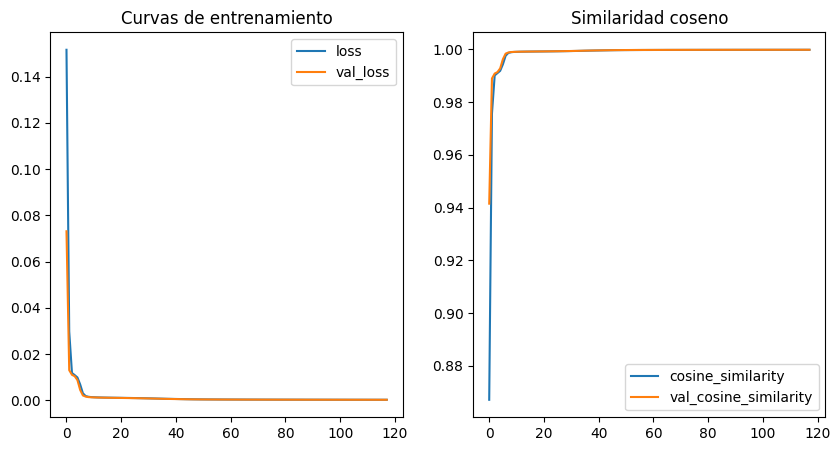

In [15]:
##Representamos las curvas de entrenamiento y las métricas empleadas en el proceso de entrenamiento
history_df = pd.DataFrame(history.history)

#Creamos la figura y la grid donde vamos a generar los gráficos
figure = plt.figure(figsize = (10, 5)) #Definimos la figura y su tamaño
grid = gridspec.GridSpec(1, 2, width_ratios = [1, 1]) #Definimos la grid con el número de filas y columnas

#Añadimos el primer gráfico al primer espacio de la cuadricula: curvas de entrenamiento (función de coste)
ax0 = plt.subplot(grid[0])
history_df.loc[:, ["loss", "val_loss"]].plot(ax = ax0) #Con el argumento de la funcion plot() ax = ax0 indicamos que el gráfico corresponde al hueco de la grid asociado a ax0
ax0.set_title("Curvas de entrenamiento")

#Añadimos el segundo gráfico al segundo espacio de la cuadricula: metricas calculadas en el proceso de entrenamiento (similaridad coseno)
ax1 = plt.subplot(grid[1])
history_df.loc[:, ["cosine_similarity", "val_cosine_similarity"]].plot(ax = ax1)
ax1.set_title("Similaridad coseno") 

In [27]:
##Cargamos el modelo entrenado y congelamos los pesos para que no se puedan modificcar en posibles procesos de entrenamiento
autoencoder = load_model("/home/jupyter-manuel/Digiopt/Models/AE_V1_HyperModel_2.keras", custom_objects = {'Autoencoder_V1': Autoencoder_V1})
autoencoder.trainable = False

#Aplicamos el encoder y el decoder a las señales del conjunto de validación, de tal manera que obtenemos la representacion en el espacio de dimensión reducida y la señal reconstruida
encoded_signal = autoencoder.encoder(X_valid_tf).numpy()
decoded_signal = autoencoder.decoder(encoded_signal).numpy()

#Calculamos el error de reconstrucción promedio dado por el autoencoder mediante el indicador MSE
rmse = np.sqrt(np.mean((X_valid - autoencoder.predict(X_valid)) ** 2))
print(rmse)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
0.031220929723026522


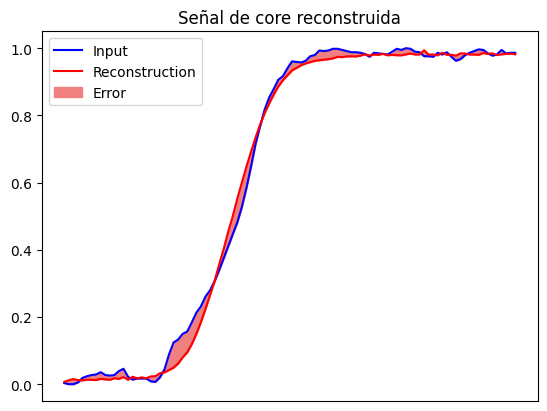

In [41]:
##Representamos en el mismo gráfico la señal original, la señal reconstruida y el error de reconstruccion para una señal aleatoria del conjunto de validación
n_random = random.randint(1, 170)
plt.plot(X_valid.iloc[n_random], "b")
plt.plot(decoded_signal[n_random], "r")
plt.fill_between(np.arange(100), decoded_signal[n_random], X_valid.iloc[n_random], color = "lightcoral")
plt.legend(labels = ["Input", "Reconstruction", "Error"])
plt.title("Señal de core reconstruida")
plt.xticks([])
plt.show()

488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


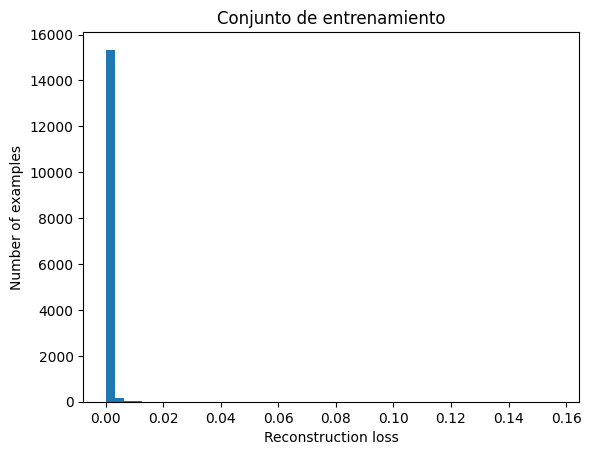

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


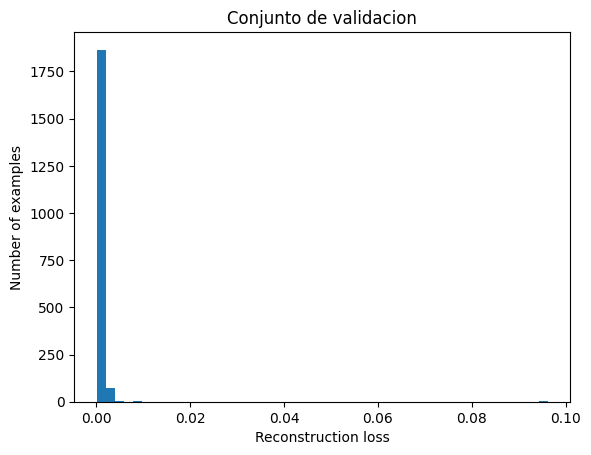

In [42]:
##Aplicamos el modelo al conjunto de entrenamiento para determinar las reconstrucciones dadas por el modelo
reconstructed_train = autoencoder.predict(X_train)
#Calculamos el error de reconstrucción entre las funciones de entrada y las reconstruidas
train_loss = tf.keras.losses.mse(reconstructed_train, X_train)
#Histograma de los valores del error de reconstrucción para el conjuto de entrenamiento
plt.hist(train_loss[None,:], bins = 50)
plt.title("Conjunto de entrenamiento")
plt.xlabel("Reconstruction loss")
plt.ylabel("Number of examples")
plt.show()

##Realizamos el mismo proceso para el conjunto de validación
#Reconstrucción dada por el modelo
reconstructed_valid = autoencoder.predict(X_valid)
#Error de reconstrucción
test_loss = tf.keras.losses.mse(reconstructed_valid, X_valid)
#Representación del histograma
plt.hist(test_loss[None, :], bins = 50)
plt.title("Conjunto de validacion")
plt.xlabel("Reconstruction loss")
plt.ylabel("Number of examples")
plt.show()

,0,1,2,3,4,5,6
0,0.0,16.113960,5.363393,0.0,6.369391,0.0,4.389741
1,0.0,14.602953,7.333107,0.0,8.551682,0.0,6.369740
2,0.0,15.549341,4.873925,0.0,6.141772,0.0,4.136701
3,0.0,15.382915,3.007053,0.0,4.602404,0.0,2.613254
4,0.0,15.818508,5.216986,0.0,6.344612,0.0,4.349230
...,...,...,...,...,...,...,...
15609,0.0,15.578650,5.075562,0.0,6.281854,0.0,4.279754
15610,0.0,15.322274,2.172089,0.0,3.820112,0.0,1.878802
15611,0.0,15.811429,3.170373,0.0,4.647593,0.0,2.683993
15612,0.0,15.819376,2.738117,0.0,4.208598,0.0,2.303416


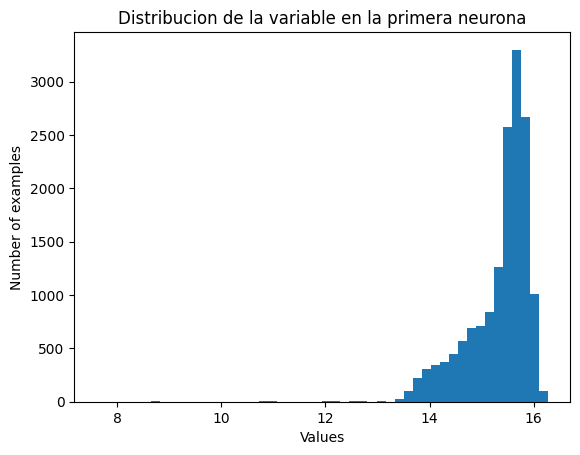

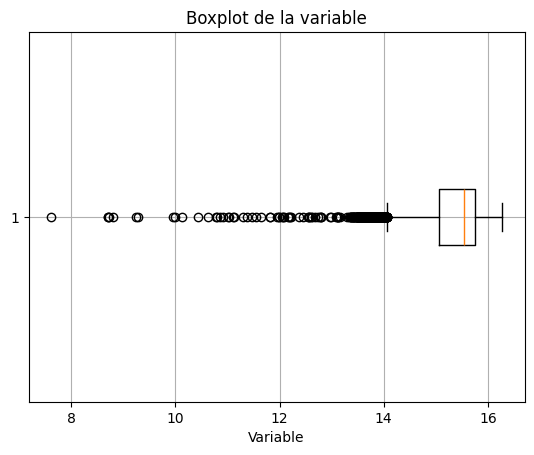

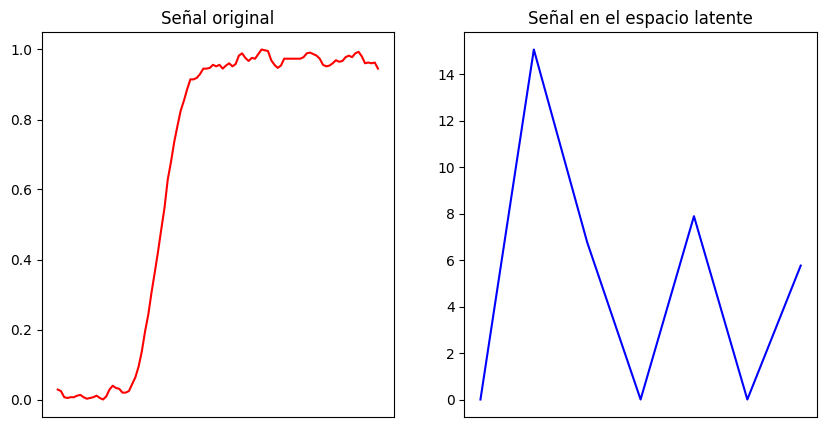

In [43]:
##Para obtener las señales en el espacio de dimensión reducida aplicamos la parte del encoder del autoencoder a las señales de entrada
reduced_signal = tf.squeeze(autoencoder.encoder(X_train_tf)).numpy() #Eliminamos las dimensiones del tensor que sean 1
reduced_signal_df = pd.DataFrame(reduced_signal)
display(reduced_signal_df)

#Distribución de la variable guardada en la primera neurona
plt.hist(reduced_signal_df[1], bins = 50)
plt.title("Distribucion de la variable en la primera neurona")
plt.xlabel("Values")
plt.ylabel("Number of examples")
plt.show()

#Boxplot de la variables guardada en la primera neurona
plt.boxplot(reduced_signal_df[1], vert=False)  
plt.title('Boxplot de la variable')
plt.xlabel('Variable')
plt.grid(True)
plt.show()

#Representación de las señales en el espacio de dimensión reducida y la señal original a la que corresponde
n_random = random.randint(0, 1367)
# Crear una figura y dos subgráficos en una cuadrícula de 1x2
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Graficar la señal reducida en el segundo subgráfico
axs[1].plot(reduced_signal_df.iloc[n_random], "b")
axs[1].set_title("Señal en el espacio latente")
axs[1].set_xticks([])

#Graficar la señal original en el primer subgráfico
axs[0].plot(X_train.iloc[n_random], "r")
axs[0].set_title("Señal original")
axs[0].set_xticks([])

plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


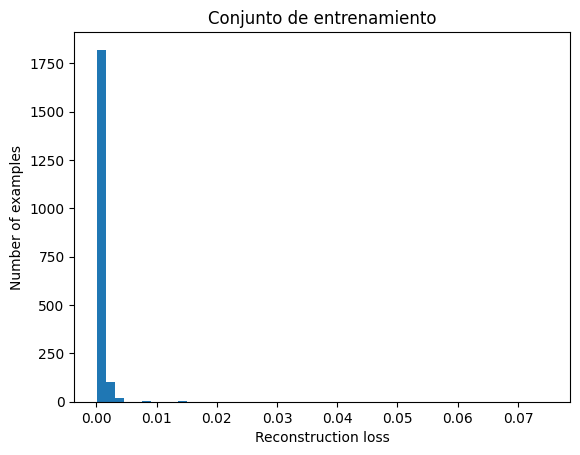

,0,1,2,3,4,5,6
0,0.0,14.361892,7.535348,0.0,8.786814,0.0,6.587113
1,0.0,15.640595,5.444987,0.0,6.572570,0.0,4.556723
2,0.0,13.497265,1.605961,0.0,3.347485,0.0,1.438341
3,0.0,15.503088,6.156158,0.0,7.275593,0.0,5.208050
4,0.0,15.921099,3.094618,0.0,4.468071,0.0,2.568390
...,...,...,...,...,...,...,...
1947,0.0,14.438005,6.791811,0.0,7.952466,0.0,5.895446
1948,0.0,15.418291,4.932870,0.0,6.272799,0.0,4.219294
1949,0.0,16.121351,3.839937,0.0,5.103561,0.0,3.170120
1950,0.0,15.905567,4.251557,0.0,5.560006,0.0,3.576389


0.015993595123291016


In [44]:
##Aplicamos el modelo al conjunto de test para determinar las reconstrucciones dadas por el modelo
reconstructed_test = autoencoder.predict(X_test)
#Calculamos el error de reconstrucción entre las funciones de entrada y las reconstruidas
train_loss = tf.keras.losses.mse(reconstructed_test, X_test)
#Histograma de los valores del error de reconstrucción para el conjuto de entrenamiento
plt.hist(train_loss[None,:], bins = 50)
plt.title("Conjunto de entrenamiento")
plt.xlabel("Reconstruction loss")
plt.ylabel("Number of examples")
plt.show()

##Para obtener las señales en el espacio de dimensión reducida aplicamos la parte del encoder del autoencoder a las señales de entrada
start = time.time()
reduced_signal = tf.squeeze(autoencoder.encoder(X_test_tf)).numpy() #Eliminamos las dimensiones del tensor que sean 1
reduced_signal_df = pd.DataFrame(reduced_signal)
display(reduced_signal_df)
end = time.time()
print(end -start)

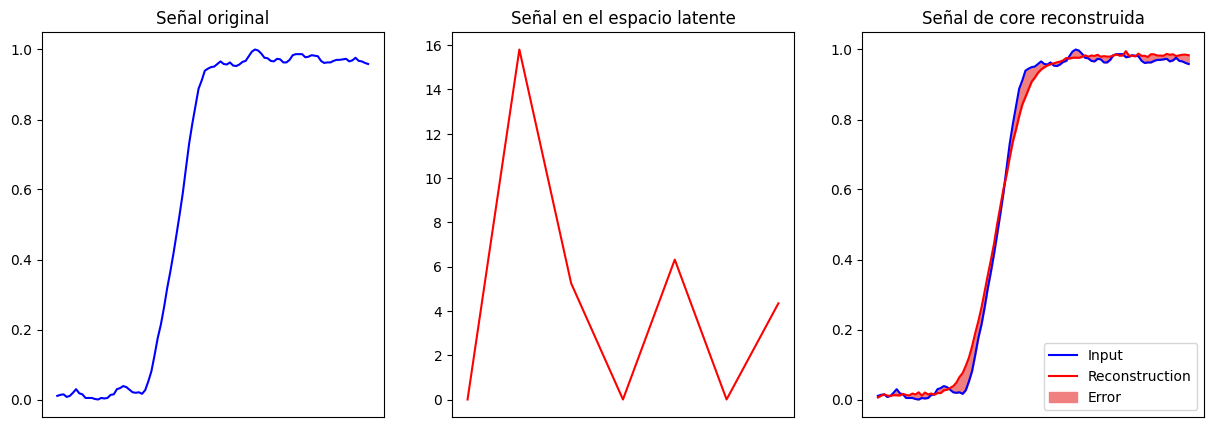

In [56]:
##Representamos a continuación tres gráficos en los que se muestra lo siguiente: Señal original, señal en el espacio de dimension reducida
#y la comparacion entre la señal original y la señal reconstruida.
n_random = random.randint(0, 171)
#Crear una figura y dos subgráficos en una cuadrícula de 1x3
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#Graficar la señal original en el primer subgráfico
axs[0].plot(X_test.iloc[n_random], "b")
axs[0].set_title("Señal original")
axs[0].set_xticks([])
#Graficar la señal reducida en el segundo subgráfico
axs[1].plot(reduced_signal_df.iloc[n_random], "r")
axs[1].set_title("Señal en el espacio latente")
axs[1].set_xticks([])
#Graficar la señal original y la señal reconstruida junto con el error de reconstrucción
axs[2].plot(X_test.iloc[n_random], "b")
axs[2].plot(reconstructed_test[n_random], "r")
axs[2].fill_between(np.arange(100), reconstructed_test[n_random], X_test.iloc[n_random], color = "lightcoral")
axs[2].legend(labels = ["Input", "Reconstruction", "Error"])
axs[2].set_title("Señal de core reconstruida")
axs[2].set_xticks([])

plt.show()

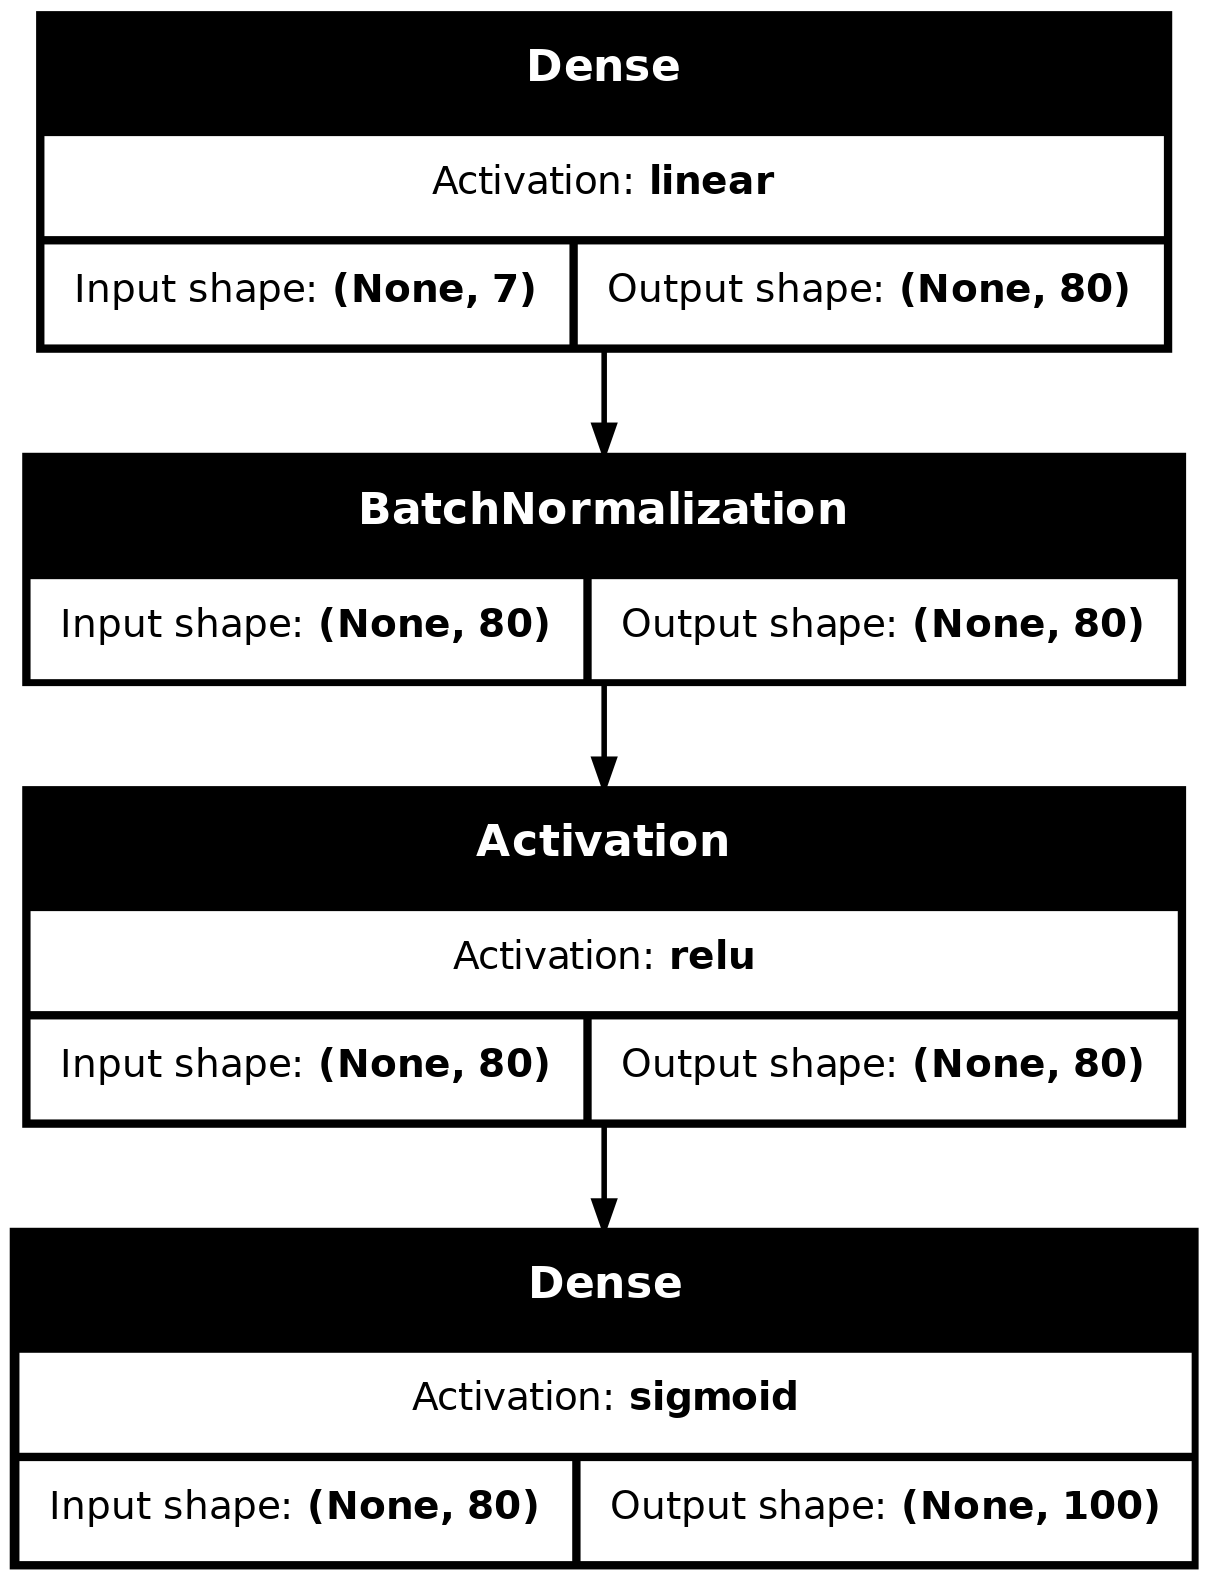

: 

: 

: 

: 

In [ ]:
#Generación de gráficos de arquitecturas
import graphviz
import pydotplus
#Generacion del gráfico en un fichero
#Arquitectura encoder
plot_model(autoencoder.encoder, to_file='/home/jupyter-manuel/Digiopt/Imagenes_arquitecturas/AE_V1_encoder.png', show_shapes = True, show_layer_activations = True)
#Arquitrectura decoder
plot_model(autoencoder.decoder, to_file='/home/jupyter-manuel/Digiopt/Imagenes_arquitecturas/AE_V1_decoder.png', show_shapes = True, show_layer_activations = True)

#Mostrar la imagen del gráfico
Image(filename='/home/jupyter-manuel/Digiopt/Imagenes_arquitecturas/AE_V1_encoder.png')
Image(filename='/home/jupyter-manuel/Digiopt/Imagenes_arquitecturas/AE_V1_decoder.png')

In [58]:
##Ejecutar siempre que se quiera liberar el espacio de la GPU y al final de cada scrip
cuda.select_device(0)
cuda.close()